In [7]:
suppressMessages(suppressWarnings({
    library(GO.db)
    library(msigdbr)
    library(graph)
    library(igraph)
    library(RBGL)
    library(Rgraphviz)
    library(ggplot2)
    library(pheatmap)
    library(data.table)
}))

# Figure 7

In [24]:
##############################################
# C5 biological processes from MSigDB
##############################################
C5 <- as.data.table(msigdbr(species = "Homo sapiens", category = "C5", subcategory = "BP"))
C5_terms <- unique(C5$gs_exact_source)

In [10]:
##############################################
# prepare the tree of GO:BP heirarchies
##############################################
xx = as.data.table(toTable(GOBPPARENTS))
colnames(xx)[1:2] <- c('from', 'to')
gg_igraph <- graph_from_data_frame(xx, directed = TRUE)
gg_graph = ftM2graphNEL(as.matrix(xx[,1:2]), W=rep(1,dim(xx)[1]))
root_GO_BP <- 'GO:0008150'

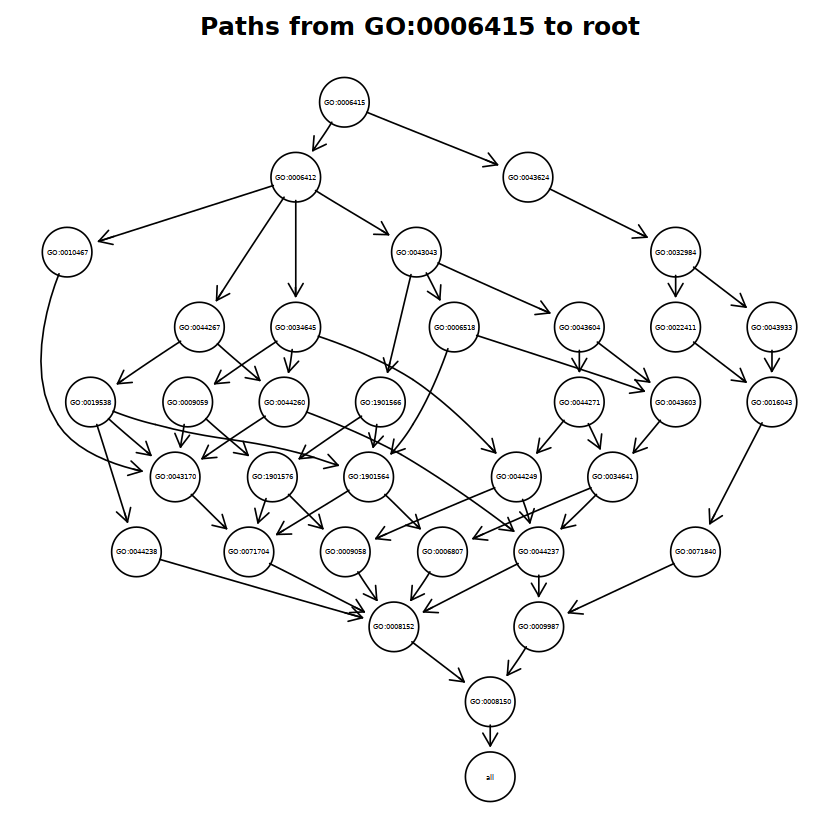

In [12]:
######################################################################################
# plot a subtree of GO:BP heirarchies starting from a given GO:BP to the root term
######################################################################################
plot_subtree_from_to_root <- function(graph, from_term){
    all_paths <- sapply(all_simple_paths(graph, from_term ,root_GO_BP), length)
    get_ancestors_subgraph <- function(graph, go_term){
        nodes <- c(get(go_term, GOBPANCESTOR), go_term)
        return(subGraph(nodes, graph))
    }
    plot(get_ancestors_subgraph(gg_graph, from_term), main = paste0('Paths from ',from_term,' to root'))
}
plot_subtree_from_to_root(gg_igraph, 'GO:0006415')

In [ ]:
#################################################################################################################
# Run this code as a series of batch job with job_index ranging from 1 to 5625
# This will produce several output files stored in out_dir
# The collection of output files will be used to compile all the 2 by 2 path legths between any pair of GO:BPs
#################################################################################################################

suppressMessages(suppressWarnings({
    library(data.table)
    library(GO.db)
    library(msigdbr)
    library(igraph)
}))

args <- commandArgs(trailingOnly = TRUE)
job_indx <- as.numeric(args[1])
out_dir <- args[2]

C5 <- as.data.table(msigdbr(species = "Homo sapiens", category = "C5", subcategory = "BP"))
C5_terms <- unique(C5$gs_exact_source)

xx = as.data.table(toTable(GOBPPARENTS))
colnames(xx)[1:2] <- c('from', 'to')
gg_igraph <- graph_from_data_frame(xx, directed = TRUE)

from_to_terms <- function(terms, d, i){
    N <- length(terms)
    get_chunk <- function(N, d, z) return(((z)*d+1):min(N, (z+1)*d))
    k <- ceiling(N/d)
    stopifnot(i <= k^2)
    from_indx <- get_chunk(N=N, d=d, z=floor((i-1)/k))
    to_indx <- get_chunk(N=N, d=d, z=(i-1)%%k)
    from_terms <- terms[from_indx]
    to_terms <- terms[to_indx]
    return(list(from=from_terms, to=to_terms))
}

path_lengths_from_to <- function(graph, from_term, to_term){
    if(from_term == to_term) return(NA)
    all_paths <- all_simple_paths(graph, from_term, to_term)
    ifelse(length(all_paths) == 0, NA, sapply(all_paths, function(p){length(p)-1}))
}

selected_terms <- from_to_terms(terms=C5_terms, d=100, i=job_indx)

dt <- list()
for(from_term in selected_terms[['from']]){
    for(to_term in selected_terms[['to']]){
        path_lengths <- path_lengths_from_to(gg_igraph, from_term, to_term)
        if(is.numeric(path_lengths)){
            dt[[length(dt)+1]] <- data.table(from=from_term, to=to_term, path_length=path_lengths)
        }
    }
}
if(length(dt) > 0){
    dt <- do.call(rbind, dt)
    saveRDS(dt, paste0(out_dir,'/dt_',job_indx))
}

In [ ]:
#################################################################################################################
# Use the results of the above code to compile all the 2 by 2 path legths between any pair of GO:BPs
#################################################################################################################

all_2by2_paths <- do.call(rbind, lapply(list.files('batch job - all 2by2 paths/out', full.names = T), readRDS))

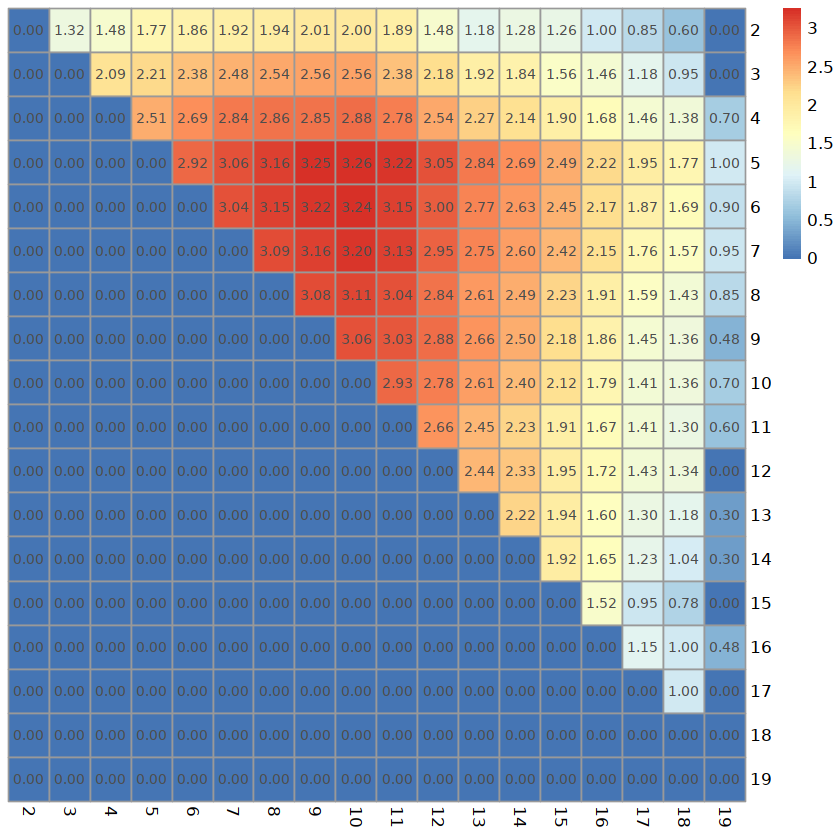

In [41]:
# obtain the length of the longest path from each GO:BP to the root term. Use this value as the granularity score
granularity_scores <- sapply(unique(C5$gs_exact_source), function(go_term){
    all_paths <- sapply(all_simple_paths(gg_igraph, go_term ,root_GO_BP), length)
    longest_path_length <- max(all_paths)
    return(longest_path_length)
})

# create a matrix storing the number of paths between GO:BPs in one granularity level and another grnularity level
grsc <- as.character(sort(unique(granularity_scores)))
m <- matrix(-1, nrow = length(grsc), ncol = length(grsc))
colnames(m) <- grsc
rownames(m) <- grsc
for(g1 in grsc){
    for(g2 in grsc){
        m[g2, g1] <- dim(all_2by2_paths[from %in% names(which(granularity_scores == g1)) &
                                        to %in% names(which(granularity_scores == g2))])[1]

    }
}

# plot the heatmap of the above mentinoed matrix (in log scale)
pheatmap(log10(m+1), cluster_rows = F, cluster_cols = F, display_numbers = T)